In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload to automatically reload all modules before executing code
%autoreload 2
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from scipy.special import expit
from collections import OrderedDict
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             f1_score, fbeta_score)

import matplotlib as matplot
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns

from modules.metrics import F1_PA, F1_W
from modules.data_split import subject_level_split, temporal_within_subject_split
from modules.inference import (safe_fmt, bootstrap_ci_of_diff, permutation_p_value, 
                               combined_significance_test, format_result_with_symbols)


# Finding (and setting) threshold

In [2]:
# Setting thresholds
threshold_ADARP = 0.501 
threshold_ROAD = 0.71
threshold_WA = 0.501 

Choose a dataset to plot probabilities for [ADARP, ROAD, WA]

In [3]:
Dataset = 'ADARP'
CON_Len, HOR_len = 2048, 256
save_path = os.path.join(Dataset,'figures')
labels = ['Non-event','Event']
ELA_Sec = 0
label_adjustment = f'ELA_{ELA_Sec}sec'  # Example label adjustment, can be set to None if not needed
ELA_suffix = f"_{label_adjustment}" if ELA_Sec else ""
val_test = 'val'

base_name = f"tfm_C{CON_Len}_H{HOR_len}_{val_test}{ELA_suffix}"

In [4]:
forecast = np.load(os.path.join(Dataset, f"{base_name}_pred.npy")).flatten()
actuals = np.load(os.path.join(Dataset, f"{base_name}_true.npy")).flatten()
timestamps = np.load(os.path.join(Dataset, f"{base_name}_timestamps.npy")).flatten()
subject_ids = np.load(os.path.join(Dataset, f"{base_name}_subject_ids.npy")).flatten()

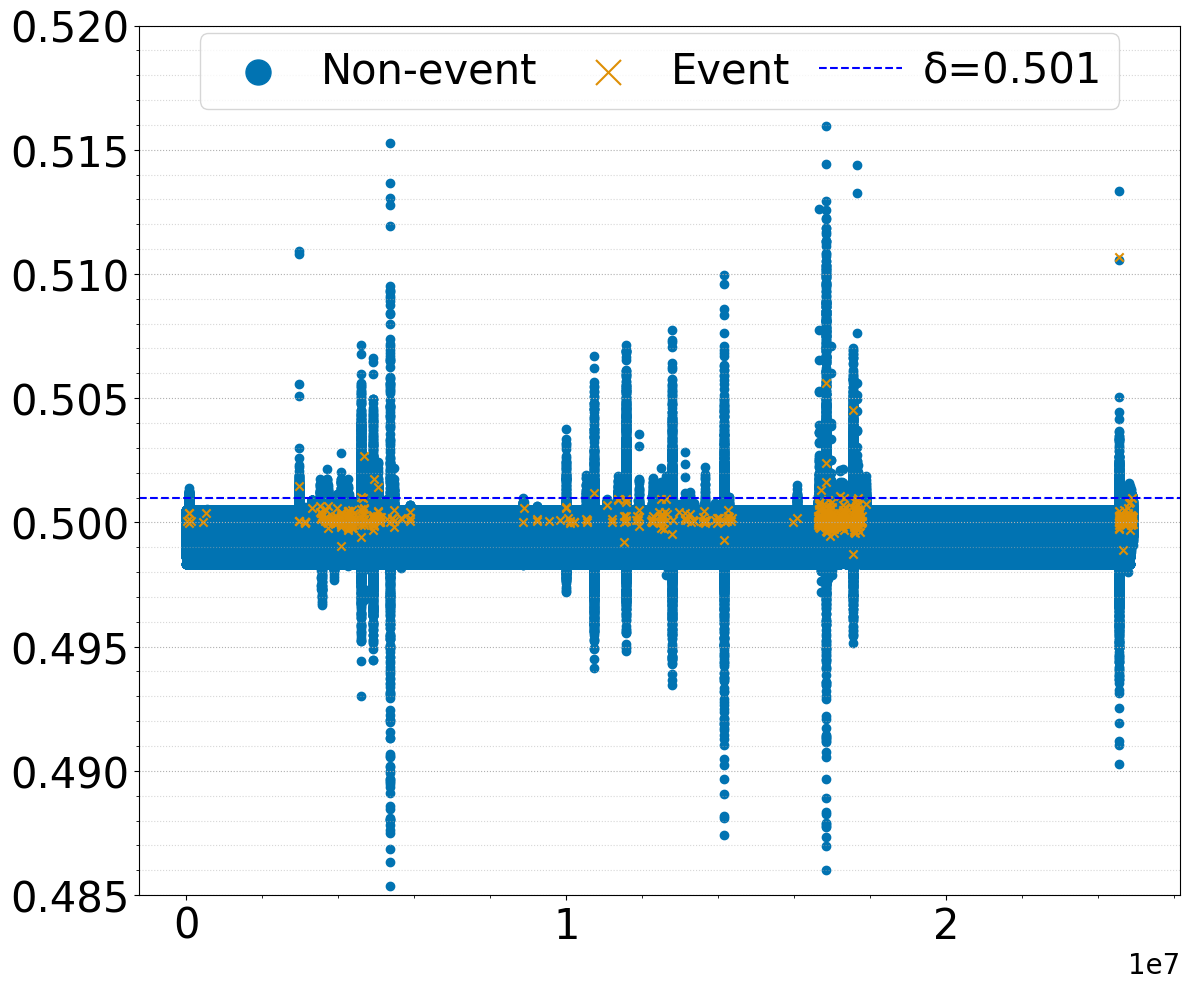

In [ ]:
import matplotlib.ticker as mticker
plt.figure(figsize=(12,10))
if Dataset == 'ADARP':
    threshold = threshold_ADARP
    major_locator = mticker.MultipleLocator(0.005)
    minor_locator = mticker.MultipleLocator(0.001)
elif Dataset == 'ROAD':
    threshold = threshold_ROAD
    major_locator = mticker.MultipleLocator(0.05)
    minor_locator = mticker.MultipleLocator(0.01)
elif Dataset == 'WA':
    threshold = threshold_WA
    major_locator = mticker.MultipleLocator(0.005)
    minor_locator = mticker.MultipleLocator(0.001)
else:
    raise ValueError("Dataset not recognized. Please set the threshold accordingly.")


y_prob = expit(forecast)
idx    = np.arange(len(y_prob))
colors = sns.color_palette("colorblind", 2) # Color Blind friend color map
labels = ['Non-event','Event']
markers = ['o', 'x'] # Distinct markers


for val, clr, lab, marker in zip([0,1], colors, labels, markers):
    if val == 1:
        mask = (actuals == val)
        plt.scatter(idx[mask], y_prob[mask],
                    color=clr, label=lab, marker=marker)
    else:
        step = 1  # plot every 5th point
        mask = (actuals == val)
        idx_masked = idx[mask][::step]
        y_prob_masked = y_prob[mask][::step]
        plt.scatter(idx_masked, y_prob_masked, color=clr, label=lab, 
                    marker=marker, rasterized=True)
del mask, idx_masked, y_prob_masked
if Dataset != 'ROAD':
    plt.axhline(threshold, color='blue', linestyle='--', label=f'δ={threshold:.3f}')
else:
    plt.axhline(threshold, color='blue', linestyle='--', label=f'δ={threshold:.2f}')

if Dataset == 'ADARP':
    plt.ylim(0.476, 0.524)
if Dataset == 'ROAD':
    plt.ylim(0.61, 0.65)
if Dataset == 'WA':
    plt.ylim(0.485, 0.52)


plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.015), 
    fontsize=30,
    markerscale=3,
    ncol=3,
    columnspacing=0.7,
    handletextpad=0.5
)
plt.gca().yaxis.set_major_locator(major_locator)
plt.gca().yaxis.set_minor_locator(minor_locator)
plt.gca().yaxis.set_minor_formatter(mticker.NullFormatter())
plt.minorticks_on()
plt.grid(True, linestyle=':', which='minor', alpha=0.5)
plt.grid(True, linestyle=':', which='major')

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=30) 
ax.tick_params(axis='both', which='minor', labelsize=30)
if Dataset == 'WA' and val_test == 'val':
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=3))
else:
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
# Remove x-axis grid lines
ax.grid(False, axis='x', which='major')
ax.grid(False, axis='x', which='minor')
if Dataset == 'ADARP' or Dataset == 'WA':
    ax.xaxis.get_offset_text().set_fontsize(20)

plt.tight_layout()
if True:
    plt.savefig(os.path.join(save_path,f'{Dataset}_{val_test}_probabilites.pdf'))
plt.show()
plt.close()

# F-metrics as number (with recall and precison)

## Storing results as a dictionary

In [8]:
# Setting parameters for testing
datasets = ['ADARP', 'ROAD', 'WA']
K_values = [0, 0.25, 0.5, 0.75]
window_sizes = [10, 30, 60, 300, 1200, 3600]  # seconds: 30s, 1min, 5min, 20min, 60min
betas = [0.5, 2]

val_test = 'test'
CON_Len, HOR_len = 2048, 256
ELA_Sec = 0
label_adjustment = f'ELA_{ELA_Sec}sec'
ELA_suffix = f"_{label_adjustment}" if ELA_Sec else ""
base_name = f"tfm_C{CON_Len}_H{HOR_len}_{val_test}{ELA_suffix}"

In [9]:
# Prepare a tot_results_tab dictionary: tot_results_tab[eval_type][metric][ds] = value
tot_results_tab = {}

for ds in tqdm(datasets, desc="Processing datasets"):
    try:
        forecast = np.load(os.path.join(ds, f"{base_name}_pred.npy")).flatten()
        actuals = np.load(os.path.join(ds, f"{base_name}_true.npy")).flatten()
        timestamps = np.load(os.path.join(ds, f"{base_name}_timestamps.npy")).flatten()
        subject_ids = np.load(os.path.join(ds, f"{base_name}_subject_ids.npy")).flatten()
            # --- binarize forecast ---
        if ds == 'ADARP':
            thresh = threshold_ADARP
        elif ds == 'ROAD':
            thresh = threshold_ROAD
        elif ds == 'WA':
            thresh = threshold_WA
        else:
            raise ValueError(f"Unknown dataset: {ds}")
        y_true = actuals.astype(int)
        y_bin = expit(forecast)
        y_pred = (y_bin > thresh).astype(int)
    except Exception as e:
        print(f"Error loading data for {ds}: {e}")
        continue

    # Standard metrics
    tot_results_tab.setdefault('F1', {})[ds] = f1_score(y_true, y_pred)
    tot_results_tab.setdefault('Precision', {})[ds] = precision_score(y_true, y_pred)
    tot_results_tab.setdefault('Recall', {})[ds] = recall_score(y_true, y_pred)
    for beta in betas:
        tot_results_tab.setdefault(f'Fβ={beta}', {})[ds] = fbeta_score(y_true, y_pred, beta=beta)

    # PA Evaluation
    for K in K_values:
        f1_pa, prec_pa, rec_pa, fdr_pa = F1_PA(y_true, y_pred, K=K)
        tot_results_tab.setdefault(f'F1_PA_K={K}', {})[ds] = f1_pa
        tot_results_tab.setdefault(f'Prec_PA_K={K}', {})[ds] = prec_pa
        tot_results_tab.setdefault(f'Rec_PA_K={K}', {})[ds] = rec_pa

    # Windowed Evaluation
    timestamps_sec = (timestamps.astype('datetime64[ns]') - timestamps.min()) / np.timedelta64(1, 's')
    for w in window_sizes:
        f1_w, prec_w, rec_w, fdr_w = F1_W(
            y_true, y_pred, recall_window_size=w, timestamps=timestamps_sec, subject_ids=subject_ids
        )
        tot_results_tab.setdefault(f'F1_W_{w}s', {})[ds] = f1_w
        tot_results_tab.setdefault(f'Prec_W_{w}s', {})[ds] = prec_w
        tot_results_tab.setdefault(f'Rec_W_{w}s', {})[ds] = rec_w

    del forecast, actuals, timestamps, subject_ids, y_true, y_bin, y_pred
with open(os.path.join('interim',f'{val_test}_tot_results_tab.pkl'), 'wb') as f:
    pickle.dump(tot_results_tab, f)


Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing datasets: 100%|██████████| 3/3 [04:18<00:00, 86.03s/it] 


In [10]:
# Load the results from the pickle file (only necessary if code block above has not been run)
with open(os.path.join('interim',f'{val_test}_tot_results_tab.pkl'), 'rb') as f:
    tot_results_tab = pickle.load(f)

## Preparing results for latex table

In [11]:
# Build comprehensive metrics order - grouped by hyperparameter
metrics_order = [
    # Standard metrics
    'F1', 'Precision', 'Recall',
    'Fβ=0.5', 'Fβ=2'
]

# Add PA metrics grouped by K value
for K in K_values:  # Key K values only
    metrics_order.extend([
        f'F1_PA_K={K}',
        f'Prec_PA_K={K}', 
        f'Rec_PA_K={K}'
    ])

# Add windowed metrics grouped by window size
for w in window_sizes:  # Key window sizes only
    metrics_order.extend([
        f'F1_W_{w}s',
        f'Prec_W_{w}s',
        f'Rec_W_{w}s'
    ])

# Build DataFrame
df = pd.DataFrame(
    [[safe_fmt(tot_results_tab.get(m, {}).get(ds)) for ds in datasets] for m in metrics_order],
    index=metrics_order,
    columns=datasets
)

# Enhanced pretty labels
pretty_labels = {
    'F1': r'F1',
    'Precision': r'Precision', 
    'Recall': r'Recall',
    'Fβ=0.5': r'F$_{0.5}$',
    'Fβ=2': r'F$_{2}$'
}

# PA labels
for K in K_values:
    pretty_labels[f'F1_PA_K={K}'] = r'F1$_{\text{PA}}$' if K == 0 else r'F1$_{\text{PA,50\%}}$'
    pretty_labels[f'Prec_PA_K={K}'] = r'Prec$_{\text{PA}}$' if K == 0 else r'Prec$_{\text{PA,50\%}}$'
    pretty_labels[f'Rec_PA_K={K}'] = r'Rec$_{\text{PA}}$' if K == 0 else r'Rec$_{\text{PA,50\%}}$'

# Windowed labels
for w in window_sizes:
    time_label = f'{w}s' if w < 60 else f'{w//60}min'
    pretty_labels[f'F1_W_{w}s'] = f'F1$_{{w,\\text{{{time_label}}}}}$'
    pretty_labels[f'Prec_W_{w}s'] = f'Prec$_{{w,\\text{{{time_label}}}}}$'
    pretty_labels[f'Rec_W_{w}s'] = f'Rec$_{{w,\\text{{{time_label}}}}}$'

# Build LaTeX table
latex_rows = []

# Table header
latex_rows.append(r"\begin{table}[ht]")
latex_rows.append(r"\centering")
latex_rows.append(r"\caption{Performance comparison across datasets. Metrics are grouped by hyperparameter: Point-Adjusted ($K$) and Windowed ($w$).}")
latex_rows.append(r"\label{tab:performance_comparison}")
latex_rows.append(r"\small")
latex_rows.append(r"\begin{tabular}{@{}l*{3}{c}@{}}")
latex_rows.append(r"\toprule")
latex_rows.append(r"Metric & \textbf{ADARP} & \textbf{ROAD} & \textbf{WA} \\")
latex_rows.append(r"\midrule")

# 1. Standard metrics
latex_rows.append(r"\multicolumn{4}{@{}l@{}}{\textbf{Standard Metrics}} \\")
latex_rows.append(r"\addlinespace[0.5ex]")
for idx in ['F1', 'Precision', 'Recall']:
    row = f"\\hspace{{1em}}{pretty_labels[idx]} & " + " & ".join(df.loc[idx]) + r" \\"
    latex_rows.append(row)

latex_rows.append(r"\addlinespace[1ex]")

# 2. F-beta metrics
latex_rows.append(r"\multicolumn{4}{@{}l@{}}{\textbf{F-beta Variants}} \\")
latex_rows.append(r"\addlinespace[0.5ex]")
for idx in ['Fβ=0.5', 'Fβ=2']:
    row = f"\\hspace{{1em}}{pretty_labels[idx]} & " + " & ".join(df.loc[idx]) + r" \\"
    latex_rows.append(row)

latex_rows.append(r"\addlinespace[1ex]")

# 3. Point-Adjusted metrics - grouped by K
latex_rows.append(r"\multicolumn{4}{@{}l@{}}{\textbf{Point-Adjusted Metrics}} \\")
for K in K_values:
    latex_rows.append(r"\addlinespace[0.5ex]")
    k_label = "K = 0" if K == 0 else f"K = {K}"
    latex_rows.append(f"\\multicolumn{{4}}{{@{{}}l@{{}}}}{{\\hspace{{1em}}{k_label}}} \\\\")
    latex_rows.append(r"\addlinespace[0.3ex]")
    for metric_type in ['F1', 'Prec', 'Rec']:
        idx = f'{metric_type}_PA_K={K}'
        row = f"\\hspace{{2em}}{pretty_labels[idx]} & " + " & ".join(df.loc[idx]) + r" \\"
        latex_rows.append(row)

latex_rows.append(r"\addlinespace[1ex]")

# 4. Windowed metrics - grouped by window size
latex_rows.append(r"\multicolumn{4}{@{}l@{}}{\textbf{Windowed Metrics}} \\")
for w in window_sizes:
    latex_rows.append(r"\addlinespace[0.5ex]")
    w_label = f"$w$ = {w}s" if w < 60 else f"$w$ = {w//60}min"
    latex_rows.append(f"\\multicolumn{{4}}{{@{{}}l@{{}}}}{{\\hspace{{1em}}{w_label}}} \\\\")
    latex_rows.append(r"\addlinespace[0.3ex]")
    for metric_type in ['F1', 'Prec', 'Rec']:
        idx = f'{metric_type}_W_{w}s'
        row = f"\\hspace{{2em}}{pretty_labels[idx]} & " + " & ".join(df.loc[idx]) + r" \\"
        latex_rows.append(row)

latex_rows.append(r"\bottomrule")
latex_rows.append(r"\end{tabular}")
latex_rows.append(r"\end{table}")

# Print the LaTeX table
print("\n".join(latex_rows))

\begin{table}[ht]
\centering
\caption{Performance comparison across datasets. Metrics are grouped by hyperparameter: Point-Adjusted ($K$) and Windowed ($w$).}
\label{tab:performance_comparison}
\small
\begin{tabular}{@{}l*{3}{c}@{}}
\toprule
Metric & \textbf{ADARP} & \textbf{ROAD} & \textbf{WA} \\
\midrule
\multicolumn{4}{@{}l@{}}{\textbf{Standard Metrics}} \\
\addlinespace[0.5ex]
\hspace{1em}F1 & 0.0001 & 0.8756 & 0.0013 \\
\hspace{1em}Precision & 0.0000 & 0.9022 & 0.0007 \\
\hspace{1em}Recall & 0.0032 & 0.8506 & 0.0098 \\
\addlinespace[1ex]
\multicolumn{4}{@{}l@{}}{\textbf{F-beta Variants}} \\
\addlinespace[0.5ex]
\hspace{1em}F$_{0.5}$ & 0.0001 & 0.8914 & 0.0009 \\
\hspace{1em}F$_{2}$ & 0.0002 & 0.8604 & 0.0028 \\
\addlinespace[1ex]
\multicolumn{4}{@{}l@{}}{\textbf{Point-Adjusted Metrics}} \\
\addlinespace[0.5ex]
\multicolumn{4}{@{}l@{}}{\hspace{1em}K = 0} \\
\addlinespace[0.3ex]
\hspace{2em}F1$_{\text{PA}}$ & 0.0001 & 0.9443 & 0.0013 \\
\hspace{2em}Prec$_{\text{PA}}$ & 0.0000 & 0.91

# F-metrics as bar plot

## Storing F-metric results as dictionary (for me, remember to use these scores below!)

In [12]:
# Setting parameters for testing
datasets = ['ADARP', 'ROAD', 'WA']
K_values     = [0.0, 0.5] # K = 1; recovers normal F1-metric
window_sizes = [10, 30, 300, 1200]   # seconds: 10s, 30s, 5min, 20min
betas        = [0.5, 2]

val_test = 'test'
CON_Len, HOR_len = 2048, 256
ELA_Sec = 0
suffix  = f"_ELA_{ELA_Sec}sec" if ELA_Sec else ""
base_name = f"tfm_C{CON_Len}_H{HOR_len}_{val_test}{suffix}"

In [13]:
results_bar = {}
for ds in datasets:
    # --- load raw arrays ---
    pred      = np.load(os.path.join(ds, f"{base_name}_pred.npy")).ravel()
    true      = np.load(os.path.join(ds, f"{base_name}_true.npy")).ravel().astype(int)
    timestamps= np.load(os.path.join(ds, f"{base_name}_timestamps.npy")).ravel()
    subject_ids = np.load(os.path.join(ds, f"{base_name}_subject_ids.npy")).ravel()
    # --- binarize forecast ---
    y_prob = expit(pred)
    if ds == 'ADARP':
        thresh = threshold_ADARP
    elif ds == 'ROAD':
        thresh = threshold_ROAD
    elif ds == 'WA':
        thresh = threshold_WA
    else:
        raise ValueError(f"Unknown dataset: {ds}")
    y_pred = (y_prob > thresh).astype(int)

    # --- random baseline ---
    y_rand = np.random.randint(0, 2, size=y_pred.shape)

    # 1) Normal F1 and F_beta
    results_bar.setdefault('Normal', {})
    results_bar['Normal'].setdefault('F1', {})[ds] = f1_score(true, y_pred)
    for b in tqdm(betas, desc=f"Processing {ds} betas for TimesFM"):
        key = f"Fβ={b}"
        results_bar['Normal'].setdefault(key, {})[ds] = fbeta_score(true, y_pred, beta=b)

    # 2) PA F1 (K values)
    for K in tqdm(K_values, desc=f"Processing {ds} K values for TimesFM"):
        f1_pa, *_ = F1_PA(true, y_pred, K=K)
        tag = f"PA_K={K}"
        results_bar.setdefault(tag, {}).setdefault('F1', {})[ds] = f1_pa

    # 3) Windowed F1 (window_sizes)
    t_sec = (timestamps.astype('datetime64[ns]') - timestamps.min())/np.timedelta64(1,'s')
    for w in tqdm(window_sizes, desc=f"Processing {ds} window sizes for TimesFM"):
        f1_w, *_ = F1_W(true, y_pred, recall_window_size=w,
                        timestamps=t_sec, subject_ids=subject_ids)
        tag = f"W_{w}s"
        results_bar.setdefault(tag, {}).setdefault('F1', {})[ds] = f1_w

    # 4) Same metrics for y_rand baseline
    # repeat steps above but replace y_pred→y_rand
    results_bar.setdefault('Rand', {})
    results_bar['Rand'].setdefault('F1', {})[ds] = f1_score(true, y_rand)
    for b in tqdm(betas, desc=f"Processing {ds} betas for Random Baseline"):
        key = f"Fβ={b}"
        results_bar['Rand'].setdefault(key, {})[ds] = fbeta_score(true, y_rand, beta=b)
    for K in tqdm(K_values, desc=f"Processing {ds} K values for Random Baseline"):
        f1_pa, *_ = F1_PA(true, y_rand, K=K)
        tag = f"PA_K={K}"
        results_bar['Rand'].setdefault(tag, {}).setdefault('F1', {})[ds] = f1_pa
    for w in tqdm(window_sizes, desc=f"Processing {ds} window sizes for Random Baseline"):
        f1_w, *_ = F1_W(true, y_rand, recall_window_size=w,
                        timestamps=t_sec, subject_ids=subject_ids)
        tag = f"W_{w}s"
        results_bar['Rand'].setdefault(tag, {}).setdefault('F1', {})[ds] = f1_w
    del pred, true, timestamps, subject_ids, y_prob, y_pred, y_rand

with open(os.path.join('interim', f'{val_test}_results_bar.pkl'), 'wb') as f:
    pickle.dump(results_bar, f)

Processing ADARP K values for Random Baseline: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]
Processing ADARP window sizes for Random Baseline: 100%|██████████| 4/4 [00:15<00:00,  3.76s/it]
Processing WA window sizes for Random Baseline: 100%|██████████| 4/4 [00:45<00:00, 11.46s/it]


In [14]:
# Load the results from the pickle file (only necessary if code block above has not been run)
with open(os.path.join('interim', f'{val_test}_results_bar.pkl'), 'rb') as f:
    results = pickle.load(f)

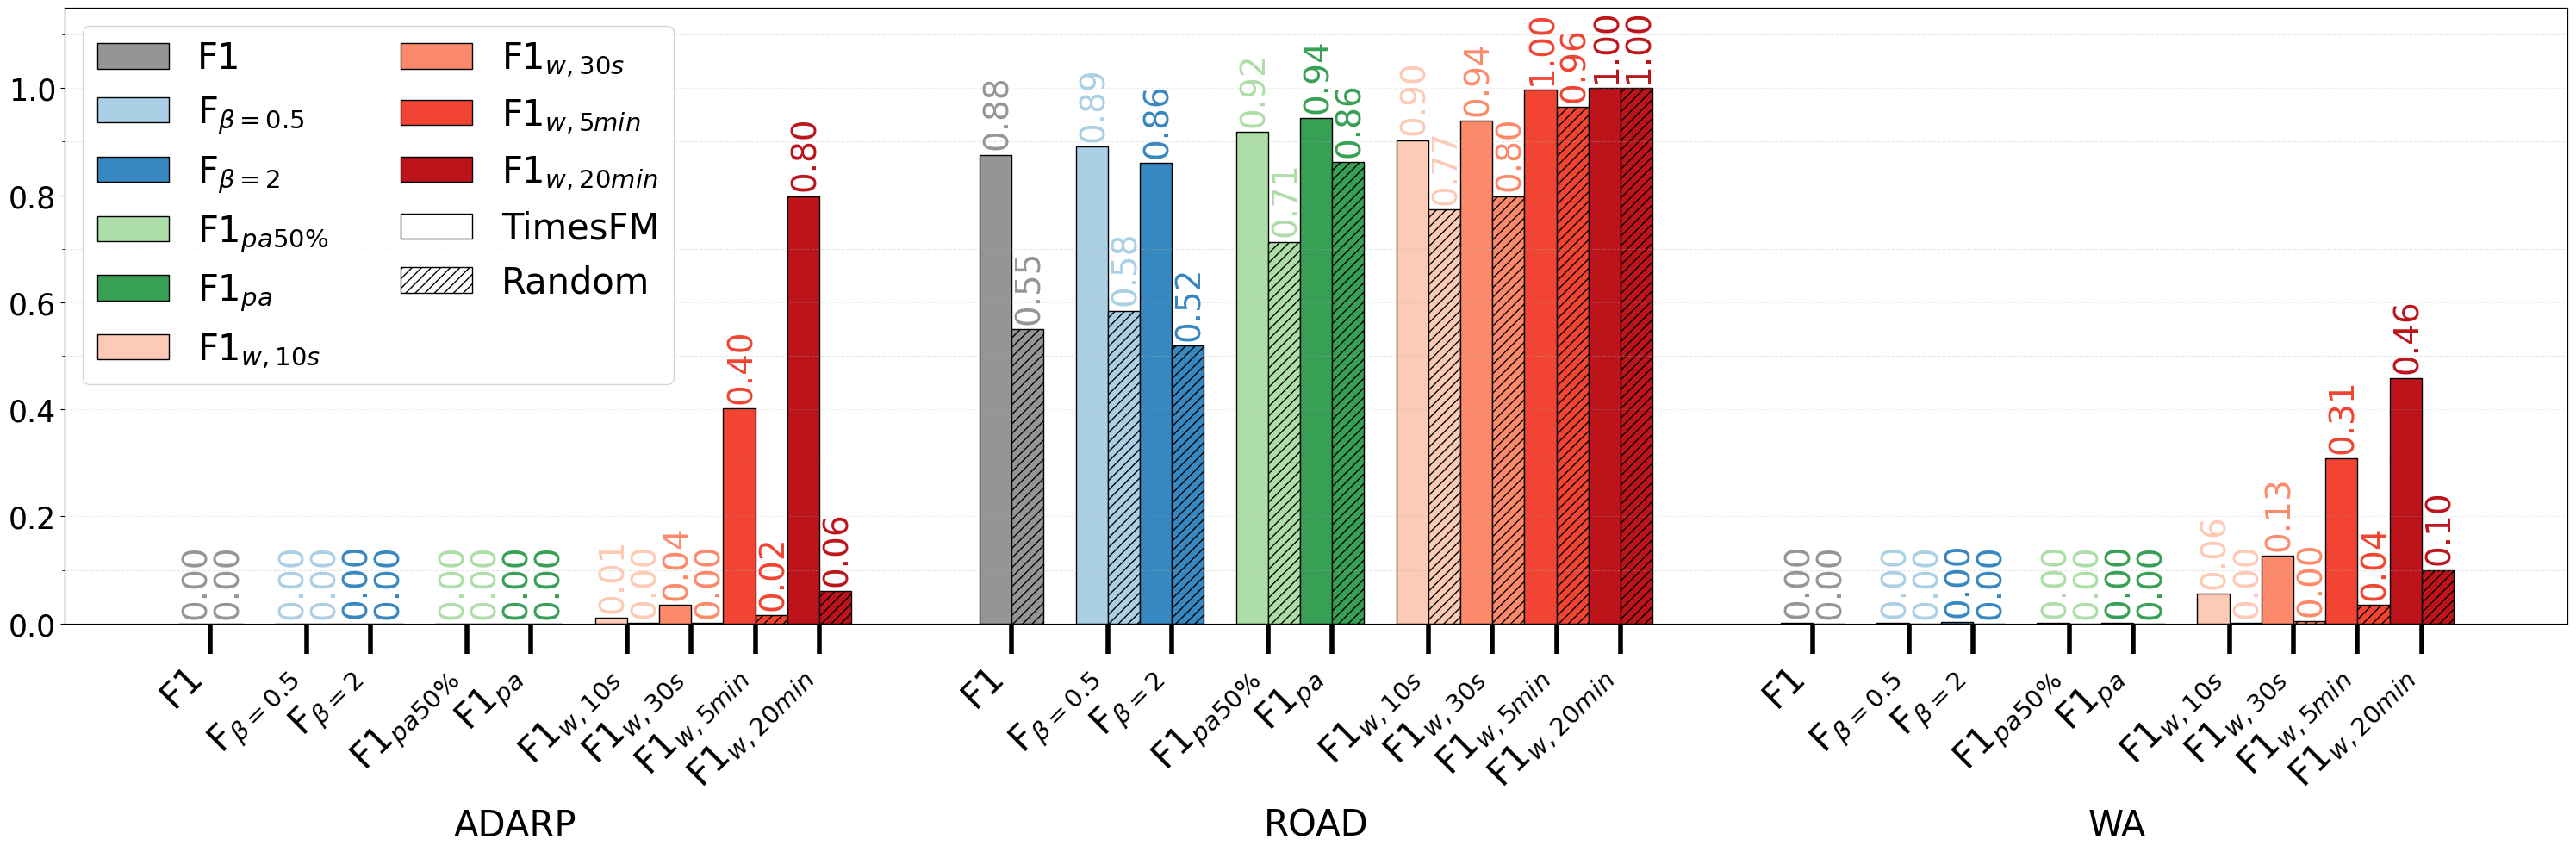

In [16]:
groups = [
    ('Std',   [('Normal','F1',     r'F1')]),
    ('Fbeta', [('Normal','Fβ=0.5', r'F$_{β=0.5}$'),
               ('Normal','Fβ=2', r'F$_{β=2}$')]),
    ('PA',    [('PA_K=0.5','F1',   r'F1$_{pa50\%}$'),
               ('PA_K=0.0','F1',   r'F1$_{pa}$')]),
    ('W',     [('W_10s','F1',      r'F1$_{w,10s}$'),
                ('W_30s','F1',      r'F1$_{w,30s}$'),
               ('W_300s','F1',     r'F1$_{w,5min}$'),
               ('W_1200s','F1',    r'F1$_{w,20min}$')]),
]

palettes = { grp: sns.color_palette(p, len(mets))
             for (grp, mets), p in zip(groups,
                 ['Greys','Blues','Greens','Reds']) }

method_extra = {'pred':'','rand':'///'} # hatch the random baseline bar plot

bar_w     = 0.3 # bar width
subgap    = bar_w # width between bars
group_gap = bar_w * 4 # width between groups
n_metrics = sum(len(mets) for _, mets in groups)
group_width = n_metrics*2*bar_w + (len(groups)-1)*subgap
starts    = np.arange(len(datasets)) * (group_width + group_gap)

fig, ax = plt.subplots(figsize=(30,10))

x_centers_all = []
labels_all    = []

group_boundaries = []

for i, ds in enumerate(datasets):
    base   = starts[i]
    offset = 0
    for grp_label, mets in groups:
        for j, (main_key, metric_key, label) in enumerate(mets):
            x_center = base + offset + (j*2+1)*bar_w
            x_centers_all.append(x_center)
            labels_all.append(label)
            for k, method in enumerate(['pred','rand']):
                if method=='pred':
                    v = (results_bar['Normal' if main_key=='Normal' else main_key]['F1' if main_key!='Normal' else metric_key][ds])
                else:
                    # random baseline
                    if main_key=='Normal':
                        v = results_bar['Rand'][metric_key][ds]
                    else:
                        v = results_bar['Rand'][main_key]['F1'][ds]
                x = x_center + (k-0.5)*bar_w
                color = palettes[grp_label][j]
                hatch = method_extra[method]
                ax.bar(x, v, width=bar_w,
                    facecolor=color,
                    edgecolor='black',
                    hatch=hatch)
                ax.text(x+0.02,
                    v + 0.01,
                    f"{v:.2f}",
                    ha='center',
                    va='bottom',
                    rotation=90,
                    fontsize=28,
                    color=color)
        left = base + offset 
        group_boundaries.append(left)
        # Calculate right boundary (just after last bar)
        right = base + offset + (len(mets)*2)*bar_w - subgap + bar_w
        group_boundaries.append(right)
        offset += 2*bar_w * len(mets) + subgap

ax.tick_params(axis='y', labelsize=25)

# primary x-axis: metric names
ax.set_xticks(x_centers_all)
ax.set_xticklabels(labels_all, rotation=45, ha='right', fontsize=30)

# make center ticks a bit shorter for contrast
ax.tick_params(axis='x', length=25, width=4, color='black', direction='out')

# secondary x-axis: dataset names
dataset_centers = starts + group_width/2
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(dataset_centers)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.tick_params(axis='x', length=0)
ax2.set_xticklabels(datasets, fontsize=30)
ax2.spines['bottom'].set_position(('outward', 150))
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(axis='x', labelsize=30)

ax.set_ylim(top=1.15)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))

# draw all the horizontal lines
ax.yaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
ax.yaxis.grid(True, which='major', linestyle='--', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='--')

# legend
metric_patches = []
for grp_label, mets in groups:
    for j, (_,_,label) in enumerate(mets):
        metric_patches.append(
            plt.Rectangle((0,0), 1, 1,
                          facecolor=palettes[grp_label][j],
                          edgecolor='black',
                          hatch='',       # no group hatch
                          label=label)
        )

# kkeep hatch only to distinguish Random vs TimesFM
method_patches = [
    plt.Rectangle((0,0),1,1,
                  facecolor='white',
                  edgecolor='black',
                  hatch=method_extra[m],
                  label=('TimesFM' if m=='pred' else 'Random'))
    for m in ['pred','rand']
]
ax.legend(handles=metric_patches + method_patches, fontsize=30, loc='upper left', ncol=2)

plt.tight_layout()
plt.savefig(os.path.join('figures',f'{val_test}_bar_comp.pdf'))
plt.show()

# Testing statistical significance of F-metrics

## Storing F-metrics as data frame

In [17]:
datasets     = ['ADARP', 'ROAD', 'WA']
K_values     = [0.0, 0.5, 1.0]
window_sizes = [10, 30, 300, 1200]   # seconds: 10s, 30s, 5min, 20min
betas        = [0.5, 2]

val_test = 'test'
CON_Len, HOR_len = 2048, 256
ELA_Sec = 0
suffix  = f"_ELA_{ELA_Sec}sec" if ELA_Sec else ""
base_name = f"tfm_C{CON_Len}_H{HOR_len}_{val_test}{suffix}"

In [18]:
results_bar = {}

rows = []
for ds in datasets:
    # --- load raw arrays ---
    pred      = np.load(os.path.join(ds, f"{base_name}_pred.npy")).ravel()
    true      = np.load(os.path.join(ds, f"{base_name}_true.npy")).ravel().astype(int)
    timestamps= np.load(os.path.join(ds, f"{base_name}_timestamps.npy")).ravel()
    subject_ids = np.load(os.path.join(ds, f"{base_name}_subject_ids.npy")).ravel()

    y_prob     = expit(pred)
    if ds == 'ADARP':
        thresh = threshold_ADARP
    elif ds == 'ROAD':
        thresh = threshold_ROAD
    elif ds == 'WA':
        thresh = threshold_WA
    y_pred     = (y_prob>thresh).astype(int)
    y_rand     = np.random.randint(0,2,size=y_pred.shape)
    t_sec      = (timestamps.astype('datetime64[ns]')-timestamps.min())/np.timedelta64(1,'s')

    for sub in tqdm(np.unique(subject_ids), desc=f"Processing {ds} subjects"):
        m = (subject_ids == sub)
        t_sub = true[m]
        ts_sub = t_sec[m]

        # Loop over both TimesFM and Random predictions
        for method, y_method in [('TimesFM', y_pred[m]), ('Random', y_rand[m])]:
            # 1) Standard Metrics (F1, Precision, Recall)
            rows.append(dict(dataset=ds, subject=sub, method=method, metric='F1', value=f1_score(t_sub, y_method, zero_division=0)))
            # rows.append(dict(dataset=ds, subject=sub, method=method, metric='Precision', value=precision_score(t_sub, y_method, zero_division=0)))
            # rows.append(dict(dataset=ds, subject=sub, method=method, metric='Recall', value=recall_score(t_sub, y_method, zero_division=0)))

            # 2) F-beta Metrics
            for beta in betas:
                rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'F{beta}', value=fbeta_score(t_sub, y_method, beta=beta, zero_division=0)))

            # 3) PA Metrics
            for K in K_values:
                f1, prec, rec, _ = F1_PA(t_sub, y_method, K=K)
                rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'F1_PA_K={K}', value=f1))
                # rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'Prec_PA_K={K}', value=prec))
                # rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'Rec_PA_K={K}', value=rec))

            # 4) Windowed Metrics
            for w in window_sizes:
                f1, prec, rec, _ = F1_W(t_sub, y_method, recall_window_size=w, timestamps=ts_sub, subject_ids=np.ones_like(t_sub))
                rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'F1_W_{w}s', value=f1))
                # rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'Prec_W_{w}s', value=prec))
                # rows.append(dict(dataset=ds, subject=sub, method=method, metric=f'Rec_W_{w}s', value=rec))
    del pred, true, timestamps, subject_ids, y_prob, y_pred, y_rand, t_sec

df_f1_per_sub = pd.DataFrame(rows)
df_f1_per_sub.to_csv(os.path.join('interim', f'{val_test}_f1_per_sub.csv'), index=False)

Processing WA subjects: 100%|██████████| 8/8 [03:29<00:00, 26.24s/it]


In [19]:
df_f1_per_sub = pd.read_csv(os.path.join('interim', f'{val_test}_f1_per_sub.csv'))

In [20]:
f1_metrics = sorted([
    m for m in df_f1_per_sub['metric'].unique()
    if m.startswith('F')
])

# Remove duplicates while preserving order
f1_metrics = list(OrderedDict.fromkeys(f1_metrics))


# Update stats calculation
stats_data = []
for ds in df_f1_per_sub['dataset'].unique():
    for metric in f1_metrics:
        sub_df = df_f1_per_sub[(df_f1_per_sub.dataset == ds) & (df_f1_per_sub.metric == metric)]
        tm = sub_df[sub_df.method == 'TimesFM']['value'].values
        rb = sub_df[sub_df.method == 'Random']['value'].values
        
        if len(tm) == 0: continue
        
        result = combined_significance_test(tm, rb)
        stats_data.append({
            'dataset': ds,
            'metric': metric,
            **result  # Unpack all results
        })

df_combined_stats = pd.DataFrame(stats_data)

In [21]:
# Create the table with clear notation
label_map = {
    'F1': r'F1',
    'F0.5': r'F$_{\beta=0.5}$',
    'F2': r'F$_{\beta=2}$',
    'F1_PA_K=0.0': r'F1$_{\text{pa}}$',
    'F1_PA_K=0.5': r'F1$_{\text{pa50\%}}$',
    'F1_W_10s': r'F1$_{\text{w,10s}}$',
    'F1_W_30s': r'F1$_{\text{w,30s}}$',
    'F1_W_300s': r'F1$_{\text{w,5min}}$',
    'F1_W_1200s': r'F1$_{\text{w,20min}}$',
}

# Build pivot table
pivot_combined = df_combined_stats.set_index(['metric', 'dataset']).sort_index()

# Order metrics
ordered_metrics = [m for m in label_map.keys() if m in pivot_combined.index.get_level_values('metric')]
datasets = ['ADARP', 'ROAD', 'WA']

# Update the caption to be crystal clear
latex_rows = []
latex_rows.append(r"\begin{table*}[ht]")
latex_rows.append(r"\centering")
latex_rows.append(r"\caption{Combined significance test: TimesFM must outperform both Random and Null baselines. $p$-value shown is the more conservative (higher) of the two tests. Significance stars ($^{***}P<0.001$, $^{**}P<0.01$, $^{*}P<0.05$) appear only when BOTH tests are significant. Failure indicators: $^{\nsim R}$ not significantly different from Random, $^{\nsim 0}$ not significantly different from Zero. Degenerate cases: $^{\dagger}$ all scores are 0, $^{\ddagger}$ all scores are 1.}")
latex_rows.append(r"\label{tab:combined_significance}")
latex_rows.append(r"\begin{tabular}{@{}l*{6}{c}@{}}")
latex_rows.append(r"\toprule")
latex_rows.append(r" & \multicolumn{2}{c}{\textbf{ADARP}} & \multicolumn{2}{c}{\textbf{ROAD}} & \multicolumn{2}{c}{\textbf{WA}} \\")
latex_rows.append(r"\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}")
latex_rows.append(r"\textbf{Metric} & $p$-value & 95\% CI & $p$-value & 95\% CI & $p$-value & 95\% CI \\")
latex_rows.append(r"\midrule")

for metric in ordered_metrics:
    metric_latex = label_map[metric]
    row_parts = [metric_latex]
    
    for ds in datasets:
        try:
            row_data = pivot_combined.loc[(metric, ds)]
            p_str, ci_str = format_result_with_symbols(row_data)
            row_parts.extend([p_str, ci_str])
        except KeyError:
            row_parts.extend(['-', '-'])
    
    latex_rows.append(' & '.join(row_parts) + ' \\\\')

latex_rows.append(r"\bottomrule")
latex_rows.append(r"\end{tabular}")
latex_rows.append(r"\end{table*}")

print("\n".join(latex_rows))

\begin{table*}[ht]
\centering
\caption{Combined significance test: TimesFM must outperform both Random and Null baselines. $p$-value shown is the more conservative (higher) of the two tests. Significance stars ($^{***}P<0.001$, $^{**}P<0.01$, $^{*}P<0.05$) appear only when BOTH tests are significant. Failure indicators: $^{\nsim R}$ not significantly different from Random, $^{\nsim 0}$ not significantly different from Zero. Degenerate cases: $^{\dagger}$ all scores are 0, $^{\ddagger}$ all scores are 1.}
\label{tab:combined_significance}
\begin{tabular}{@{}l*{6}{c}@{}}
\toprule
 & \multicolumn{2}{c}{\textbf{ADARP}} & \multicolumn{2}{c}{\textbf{ROAD}} & \multicolumn{2}{c}{\textbf{WA}} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
\textbf{Metric} & $p$-value & 95\% CI & $p$-value & 95\% CI & $p$-value & 95\% CI \\
\midrule
F1 & 1.000$^{\nsim R}$$^{\nsim 0}$ & [0.000, 0.000]$^{\dagger}$ & 0.004$^{**}$ & [0.288, 0.358] & 1.000$^{\nsim R}$$^{\nsim 0}$ & [0.000, 0.000]$^{\dagge

# Data statistics

In [22]:
Dataset = 'ADARP'
# Loading data frame
# Note that this is not the exact same data used by TimesFM
df = pd.read_csv(os.path.join(Dataset, f"All.csv"), parse_dates=["Time"])

In [ ]:
if Dataset == 'ROAD':
    val_df, test_df = subject_level_split(df, test_frac=0.8)
else:
    val_df, test_df = temporal_within_subject_split(df, test_frac=0.8)

In [24]:
print('Total data frame statistics: ')
print(f"Total length: {len(df)}")
print(f"Number of non-events {(df['Event_Occured']==0).sum()}")
print(f"Number of events {(df['Event_Occured']==1).sum()}")
print(f"Event percentage {(df['Event_Occured'].mean()*100):.4f}")
print('\n')

print('Val data frame statistics: ')
print(f"Total length: {len(val_df)}")
print(f"Number of non-events {(val_df['Event_Occured']==0).sum()}")
print(f"Number of events {(val_df['Event_Occured']==1).sum()}")
print(f"Event percentage {(val_df['Event_Occured'].mean()*100):.4f}")
print(f"Number of subjects in split: {len(val_df['subject_id'].unique())}")
print('\n')

print('Test data frame statistics: ')
print(f"Total length: {len(test_df)}")
print(f"Number of non-events {(test_df['Event_Occured']==0).sum()}")
print(f"Number of events {(test_df['Event_Occured']==1).sum()}")
print(f"Event percentage {(test_df['Event_Occured'].mean()*100):.4f}")
print(f"Number of subjects in split: {len(test_df['subject_id'].unique())}")

Total data frame statistics: 
Total length: 24020694
Number of non-events 24020289
Number of events 405
Event percentage 0.0017


Val data frame statistics: 
Total length: 4804142
Number of non-events 4804056
Number of events 86
Event percentage 0.0018
Number of subjects in split: 11


Test data frame statistics: 
Total length: 19216552
Number of non-events 19216233
Number of events 319
Event percentage 0.0017
Number of subjects in split: 11


# F1 metrics synthetic examples

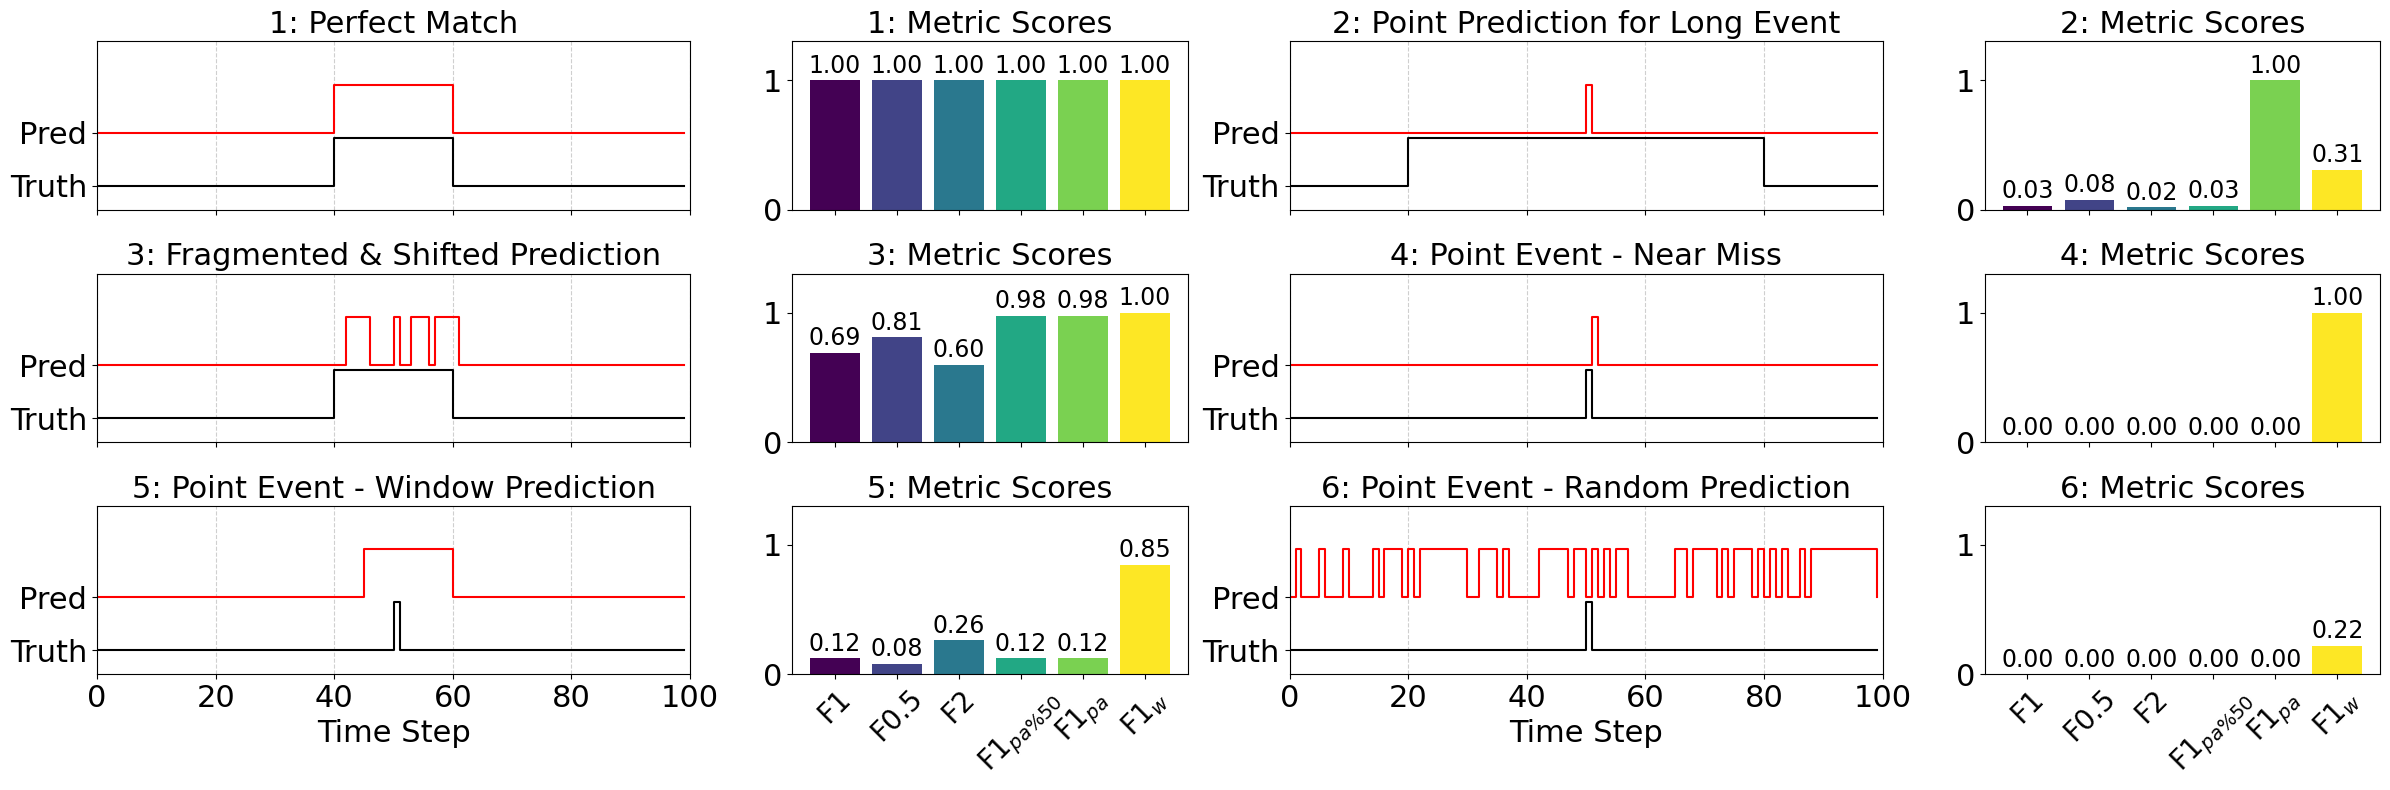

In [ ]:
scenarios = {}
T = 100 # Total time steps

# Scenario 1: Perfect Match
y_true = np.zeros(T); y_true[40:60] = 1
y_pred = np.zeros(T); y_pred[40:60] = 1
scenarios["1: Perfect Match"] = (y_true, y_pred)

# Scenario 2: Point Prediction for Long Event
y_true = np.zeros(T); y_true[20:80] = 1
y_pred = np.zeros(T); y_pred[50] = 1
scenarios["2: Point Prediction for Long Event"] = (y_true, y_pred)

# Scenario 3: Fragmented Prediction for Long Event
y_true = np.zeros(T); y_true[40:60] = 1
y_pred = np.zeros(T); y_pred[42:46] = 1; y_pred[50] = 1; y_pred[53:56] = 1; y_pred[57:61] = 1
scenarios["3: Fragmented & Shifted Prediction"] = (y_true, y_pred)

# Scenario 4: Point Event - Near Miss
y_true = np.zeros(T); y_true[50] = 1
y_pred = np.zeros(T); y_pred[51] = 1
scenarios["4: Point Event - Near Miss"] = (y_true, y_pred)

# Scenario 5: Short Event - Broad Prediction
y_true = np.zeros(T); y_true[50] = 1
y_pred = np.zeros(T); y_pred[45:60] = 1
scenarios["5: Point Event - Window Prediction"] = (y_true, y_pred)

# Scenario 6: Point Event - Random Prediction
np.random.seed(42)  # for reproducibility
y_true = np.zeros(T); y_true[50] = 1
y_pred = np.random.randint(0, 2, size=T)
scenarios["6: Point Event - Random Prediction"] = (y_true, y_pred)

label_fontsize = 22 

# Create the plot as a 3x4 grid (signal, bars) for each scenario
fig, axes = plt.subplots(3, 4, figsize=(24, 8), gridspec_kw={'width_ratios': [3, 2]*2})
ws = 10  # Window size for F1-W metric

metric_names = [
    'F1',
    'F0.5',
    'F2',
    'F1$_{pa\\%50}$',
    'F1$_{pa}$',
    'F1$_{w}$'
]
colors = plt.cm.viridis(np.linspace(0, 1, len(metric_names)))

for i, (title, (yt, yp)) in enumerate(scenarios.items()):
    row = i // 2
    col = (i % 2) * 2  # 0 or 2

    # --- Calculate all metrics ---
    f1_std = f1_score(yt, yp, zero_division=0)
    fbeta_05 = fbeta_score(yt, yp, beta=0.5, zero_division=0)
    fbeta_2  = fbeta_score(yt, yp, beta=2, zero_division=0)
    f1_pa, _, _, _ = F1_PA(yt, yp, K=None)
    f1_pa_k, _, _, _ = F1_PA(yt, yp, K=0.5)
    f1_w, _, _, _  = F1_W(yt, yp, recall_window_size=ws)

    scores = [f1_std, fbeta_05, fbeta_2, f1_pa_k, f1_pa, f1_w]

    # --- Plot 1: Signal Visualization ---
    ax1 = axes[row, col]
    ax1.step(range(T), yt, where='post', label='Ground Truth ($y_{true}$)', color='black', lw=1.5)
    ax1.step(range(T), yp + 1.1, where='post', label='Prediction ($y_{pred}$)', color='red', lw=1.5)
    ax1.set_yticks([0, 1.1])
    ax1.set_yticklabels(['Truth', 'Pred'], fontsize=label_fontsize)
    ax1.set_ylim(-0.5, 3)
    ax1.set_xlim(0, T)
    ax1.set_title(title, fontsize=label_fontsize)
    if row == 2:
        ax1.set_xlabel("Time Step", fontsize=label_fontsize)
    else:
        ax1.set_xlabel("")
        ax1.tick_params(axis='x', labelbottom=False)
    ax1.grid(True, axis='x', linestyle='--', alpha=0.6)
    ax1.tick_params(axis='both', labelsize=label_fontsize)

    # --- Plot 2: Bar chart of scores ---
    ax2 = axes[row, col+1]
    bars = ax2.bar(metric_names, scores, color=colors)
    ax2.set_ylim(0, 1.3)
    ax2.set_title(f"{i+1}: Metric Scores", fontsize=label_fontsize)
    ax2.tick_params(axis='x', labelrotation=45, labelsize=label_fontsize-2)
    ax2.tick_params(axis='y', labelsize=label_fontsize)
    if row != 2:
        ax2.set_xlabel("")
        ax2.tick_params(axis='x', labelbottom=False)
    # Add score labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=label_fontsize-5)

plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to make room for suptitle
plt.savefig(os.path.join('figures', "F1_comparison_beta_3x4.pdf"), bbox_inches='tight')
plt.show()
#